# 1. Making Streets

In [1]:
import matplotlib.pyplot
import matplotlib as mpl
import numpy as np

class Street:
    
    def __init__(self, lanes, speed_limit, length, lane_switch_probability, initial_proportion, lights, green_light_time, red_light_time, slow_down_probability, speed_up_probability, traffic_light, end = True, where = 0):
        self.lanes = lanes
        self.speed_limit = speed_limit
        self.length = length
        self.lane_switch_probability = lane_switch_probability
        self.initial_proportion = initial_proportion
        self.current_state = np.asarray([[self.speed_limit + 1]*self.length]*len(self.lanes))
        self.next_state = np.asarray([[self.speed_limit + 1]*self.length]*len(self.lanes))
        self.lights = lights
        self.traffic_light = traffic_light
        self.green_light_time = green_light_time
        self.red_light_time = red_light_time
        self.count = 0
        self.color_map = mpl.cm.PiYG.with_extremes(over = 'black')
        self.leaving_cars = []
        self.slow_down_probability = slow_down_probability
        self.speed_up_probability = speed_up_probability
        self.end = end
        self.where = where
    
    def initialize(self):
        
        #go through every cell
        for x in range(self.length):
            for y in range(len(self.lanes)):
                
                if self.lanes[y][1] == -1:
                    speed = np.random.randint(-self.speed_limit, 0)
                
                else:
                    speed = np.random.randint(1, self.speed_limit+1)
                
                if np.random.random() < self.initial_proportion:
                    self.current_state[y][x] = speed
                    
    def add_car(self, lane = None, speed = None):
        
        #if a lane is not given, assign the car to a random lane
        if lane == None:
            lane = self.lanes[np.random.randint(len(self.lanes))]
            
        #if it is a forward lane
        if lane[1] == 1:
            if speed == None:
                speed = np.random.randint(1, self.speed_limit+1)
                
            #insert the car in the first available spot at the start of the lane
            i = 0
            while self.current_state[lane[0]][i] != self.speed_limit+1 and i < len(self.current_state[lane[0]]) - 1:
                i += 1
                
            if i != len(self.current_state[lane[0]]):
                self.current_state[lane[0]][i] = speed
            
        #if it is a backwards lane, put the car at the start of it
        if lane[1] == -1:
            if speed == None:
                speed = np.random.randint(-self.speed_limit, 0)
                
            #insert the car in the first available spot at the start of the lane
            i = self.length-1
            while self.current_state[lane[0]][i] != self.speed_limit+1 and abs(i) < len(self.current_state[lane[0]]) - 1:
                i -= 1
                
            if i != len(self.current_state[lane[0]]):
                self.current_state[lane[0]][i] = speed
            
    def switch_lanes_left(self, current_lane, current_x, potential_next_position):
        
        #if the current car is not on the fastest lane
        if current_lane > 0:
            
            #if the cars in the lane on the left is going in the opposite direction
            if self.lanes[current_lane][1] != self.lanes[current_lane-1][1]:
                return False
            
            #check every cell in the other lane in front of the car
            for front_lane_switch in range(abs(potential_next_position - current_x)):
                
                if current_x + front_lane_switch*self.lanes[current_lane][1] >= self.length:
                    return False
                
                #if there is a car there the car will not switch lanes
                if self.current_state[current_lane-1][current_x + front_lane_switch*self.lanes[current_lane][1]] != self.speed_limit + 1:
                    return False

            return True
    
    def switch_lanes_right(self, current_lane, current_x, potential_next_position):
        
        #if the current car is not on the slowest lane
        if current_lane < len(self.lanes)-1:
            
            #if the cars in the lane on the right is going in the opposite direction
            if self.lanes[current_lane][1] != self.lanes[current_lane+1][1]:
                return False
            
            #check every cell in the other lane in front of the car
            for front_lane_switch in range(abs(potential_next_position - current_x)):
                
                if current_x + front_lane_switch*self.lanes[current_lane][1] >= self.length:
                    return False
                
                #if there is a car there the car will not switch lanes
                if self.current_state[current_lane+1][current_x + front_lane_switch*self.lanes[current_lane][1]] != self.speed_limit + 1:
                    return False

            return True
    
    def check_traffic_light(self):
        
        if self.traffic_light == 'green':
            if self.count % self.green_light_time == 0:
                self.traffic_light = 'red'
                self.count = 0
        
        elif self.traffic_light == 'red':
            if self.count % self.red_light_time == 0:
                self.traffic_light = 'green'
                self.count = 0
        
    def update(self):
        if self.lights == True:
            self.check_traffic_light()
        
        self.leaving_cars = []
        
        #go through every cell
        for y in range(len(self.lanes)):
            for x in range(self.length):
                
                #if the cell has a car in it
                if self.current_state[y][x] != self.speed_limit + 1:
                        
                    #what the car can do next
                    left_switch = False
                    right_switch = False
                    keep_going_straight = False
                    stop = False
                    stopped_car_in_front = False
                    
                    random_dummy = np.random.random()
                        
                    #the car can randomly slow down of speed up:
                    if random_dummy < self.slow_down_probability:
                        
                        #cars would not stop so this only happens if they are going faster than a speed of 1
                        if self.current_state[y][x]*self.lanes[y][1] > 1:
                            self.current_state[y][x] -= 1*self.lanes[y][1]
                            
                    elif random_dummy > self.slow_down_probability and random_dummy < self.slow_down_probability + self.speed_up_probability:
                        
                        #cars will not go over the speed limit and will not start moving randomly when stopped
                        if self.current_state[y][x]*self.lanes[y][1] < self.speed_limit and self.current_state[y][x] != 0:
                            self.current_state[y][x] += 1*self.lanes[y][1]
                            
                    #the next position of this car
                    potential_next_position = x + self.current_state[y][x]
                    
                    #if the next position for the car is after the end of the street it will stop
                    if potential_next_position >= self.length - 1 and self.lanes[y][1] == 1:
                        stop = True    
                        
                    if potential_next_position <= 0 and self.lanes[y][1] == -1:
                        stop = True
                        
                    #if the car is currently stopped it will stay stoped
                    if potential_next_position == x:
                        stop = True
                    
                    #if the traffic light is green, assign a speed to the car so that it can start moving
                    if self.lights == True and self.traffic_light == 'green':
                        if self.current_state[y][x] == 0:
                            new_speed = np.random.randint(1, self.speed_limit)*self.lanes[y][1]
                            self.current_state[y][x] = new_speed
                            stop = False
                            potential_next_position = int(x + self.current_state[y][x])
                        
                    #if the car does not leave the road
                    if potential_next_position <= self.length - 1 and potential_next_position >= 0:
                        
                        front = 0
                        
                        #check all the cells in front of the car if it's not stopped
                        if self.current_state[y][x] != 0:
                            
                            if self.lanes[y][1] == 1:
                                while x + front < potential_next_position:

                                    front += 1
                                    #if there is a car in front, break the loop
                                    if self.current_state[y][x + front] != self.speed_limit + 1:
                                        #if the car in front is stopped, this car will stop too
                                        if self.current_state[y][x + front] == 0:
                                            stop = True
                                            stopped_car_in_front = True

                                        break

                            if self.lanes[y][1] == -1:
                                while x + front > potential_next_position:

                                    front -= 1
                                    #if there is a car in front, break the loop
                                    if self.current_state[y][x + front] != self.speed_limit + 1:
                                        #if the car in front is stopped, this car will stop too
                                        if self.current_state[y][x + front] == 0:
                                            stop = True
                                            stopped_car_in_front = True

                                        break
                        
                        #if there is a car in front
                        if x + front != potential_next_position:
                            
                            #if the car in front is going at a smaller speed
                            if abs(self.current_state[y][x + front]) < abs(self.current_state[y][x]):
                                    
                                #if the car is going forwards and can switch lanes to overtake 
                                if self.switch_lanes_left(y, x, potential_next_position) == True and self.lanes[y][1] == 1:

                                    #a rational driver will switch lanes to overtake the car
                                    left_switch = True
                                
                                #if the car is going backwards and can switch lanes to overtake
                                elif self.switch_lanes_right(y, x, potential_next_position) == True and self.lanes[y][1] == -1:

                                    #a rational driver will switch lanes to overtake the car
                                    right_switch = True
                                    
                                #if the car can switch to the right lane and is going forwards
                                elif self.switch_lanes_right(y, x, potential_next_position) == True and self.lanes[y][1] == 1:

                                    #there is a self.lane_switch_probability that the car will switch
                                    #to the right lane
                                    if np.random.random() < self.lane_switch_probability:
                                        right_switch = True
                                    
                                    #if it can't switch it will slow down to match the speed of the car in front
                                    else:
                                        self.current_state[y][x] = self.current_state[y][x + front]
                                        keep_going_straight = True
                                
                                #if the car can switch to the left lane and is going backwards
                                elif self.switch_lanes_left(y, x, potential_next_position) == True and self.lanes[y][1] == -1:

                                    #there is a self.lane_switch_probability that the car will switch
                                    #to the right lane
                                    if np.random.random() < self.lane_switch_probability:
                                        left_switch = True
                                    
                                    #if it can't switch it will slow down to match the speed of the car in front
                                    else:
                                        self.current_state[y][x] = self.current_state[y][x + front]
                                        keep_going_straight = True
                                        
                                #if it can't switch it will slow down to match the speed of the car in front
                                else:
                                    self.current_state[y][x] = self.current_state[y][x + front]
                                    keep_going_straight = True
                            
                            #if the car in front is not going at a smaller speed
                            else:
                                
                                #it might switch lanes if it can
                                if np.random.random() < self.lane_switch_probability and self.switch_lanes_right(y, x, potential_next_position) == True and self.lanes[y][1] == 1:
                                    right_switch = True
                                
                                #it might switch lanes if it can
                                if np.random.random() < self.lane_switch_probability and self.switch_lanes_left(y, x, potential_next_position) == True and self.lanes[y][1] == -1:
                                    left_switch = True
                                
                                #if it does not switch lanes it will keep going straight
                                else:
                                    keep_going_straight = True
                        
                        #if there is no car in front
                        else:
                            
                            #if the car can switch to the right lane
                            if self.switch_lanes_right(y, x, potential_next_position) == True:

                                #there is a self.lane_switch_probability that the car will switch
                                #to the right lane
                                if np.random.random() < self.lane_switch_probability:
                                    right_switch = True
                                    
                                #if it does not switch it will keep going straight at the same speed
                                else:
                                    keep_going_straight = True
                                    
                            #if it can't switch it will keep going straight
                            else:
                                keep_going_straight = True
                                
                                #if the spot in front of the potential next position is empty the car will
                                #accelerate (if it is going below the speed limit)
                                if stop == False:
                                    
                                    if self.lanes[y][1] == 1 and potential_next_position < self.length - 1 and abs(self.current_state[y][x]) < abs(self.speed_limit-1):
                                        if self.current_state[y][potential_next_position + 1] == self.speed_limit + 1:
                                            self.current_state[y][x] += 1
                                            
                                    if self.lanes[y][1] == -1 and potential_next_position > 1 and abs(self.current_state[y][x]) < abs(self.speed_limit-1):
                                        if self.current_state[y][potential_next_position - 1] == self.speed_limit + 1:
                                            self.current_state[y][x] -= 1
                                            
                    #if it is a green light, the car will not stop or if we don't want it to stop on specific lanes (important for double intersections)
                    if (self.lights == True and self.traffic_light == 'green') or (self.end == False and self.lanes[y][1] == self.where):
                            
                        stop = False
                            
                        #if the car is not stopped and it is leaving this street, add it to the leaving_cars list
                        if (potential_next_position > self.length - 1 or potential_next_position < 0):
                            self.leaving_cars.append([self.current_state[y][x], potential_next_position, y])
                    
                    #if the light is turning green at the next time step
                    if self.lights == True and self.count % self.red_light_time == self.red_light_time - 1 and self.traffic_light == 'red':

                        #if the car currently has a speed of 0, assign it a new speed
                        if self.current_state[y][x] == 0:
                            if self.lanes[y][1] == 1:
                                new_speed = np.random.randint(1, self.speed_limit)
                            else:
                                new_speed = np.random.randint(-self.speed_limit, 0)
                                
                            self.next_state[y][x] = new_speed
                            continue
                    
                    if stop == True:
                                
                        #if the car stops and it is not because a car in front of it stopped
                        if stopped_car_in_front == False:
                            
                            #if the car's next position is inside the road it will stop there
                            if potential_next_position >= 0 and potential_next_position <= self.length-1:
                                self.next_state[y][potential_next_position] = 0
                                
                            #if the car's potential next position is outside the road, it will stop at the first
                            #available spot
                            else:
                                if self.lanes[y][1] == 1:
                                    for cell in range(potential_next_position-x, 0, -1):
                                        if x+cell >= 0 and x+cell <= self.length-1:
                                            if self.current_state[y][x+cell] == self.speed_limit+1:
                                                self.next_state[y][x+cell] = 0
                                                break
                                                
                                if self.lanes[y][1] == -1:
                                    for cell in range(x-potential_next_position, 0, -1):
                                        if x-cell >= 0 and x-cell <= self.length-1:
                                            if self.current_state[y][x-cell] == self.speed_limit+1:
                                                self.next_state[y][x-cell] = 0
                                                break
                                            
                        #if the car stops because a car in front of it stopped it will stop right behind
                        #the car that is in front
                        else:
                            self.next_state[y][x+front-1*self.lanes[y][1]] = 0
                            
                    elif right_switch == True:
                        self.next_state[y+1][potential_next_position] = self.current_state[y][x]
                        
                    elif left_switch == True:
                        self.next_state[y-1][potential_next_position] = self.current_state[y][x]
                        
                    elif keep_going_straight == True:
                        next_position = int(x + self.current_state[y][x]) - 1
                        
                        #if there is a stopped car at the next position, then reduce the next position
                        if self.next_state[y][next_position] != self.speed_limit+1:
                            while self.next_state[y][next_position] != self.speed_limit+1:
                                next_position -= 1*self.lanes[y][1]
                        
                        self.next_state[y][next_position] = self.current_state[y][x]
                        
        self.current_state = self.next_state.copy()
        self.next_state = np.asarray([[self.speed_limit + 1]*self.length]*len(self.lanes))
        self.count += 1
    
    def show_traffic_lights(self):
        if self.lights == True:
            for lane in self.lanes:
                if lane[1] == 1:
                    matplotlib.pyplot.plot([self.length-1, self.length-1], [lane[0]-0.5, lane[0] + 0.5], color = self.traffic_light, linewidth = 3)
                
                if lane[1] == -1:
                    matplotlib.pyplot.plot([0, 0], [lane[0]-0.5, lane[0] + 0.5], color = self.traffic_light, linewidth = 3)
                    
    def observe(self):
        matplotlib.pyplot.imshow(self.current_state, vmin = -self.speed_limit, vmax = self.speed_limit, cmap = self.color_map)
        self.show_traffic_lights()
    
    def animate(self, i):
        self.observe()
        self.update()
            
        return matplotlib.pyplot.show()

<IPython.core.display.Javascript object>


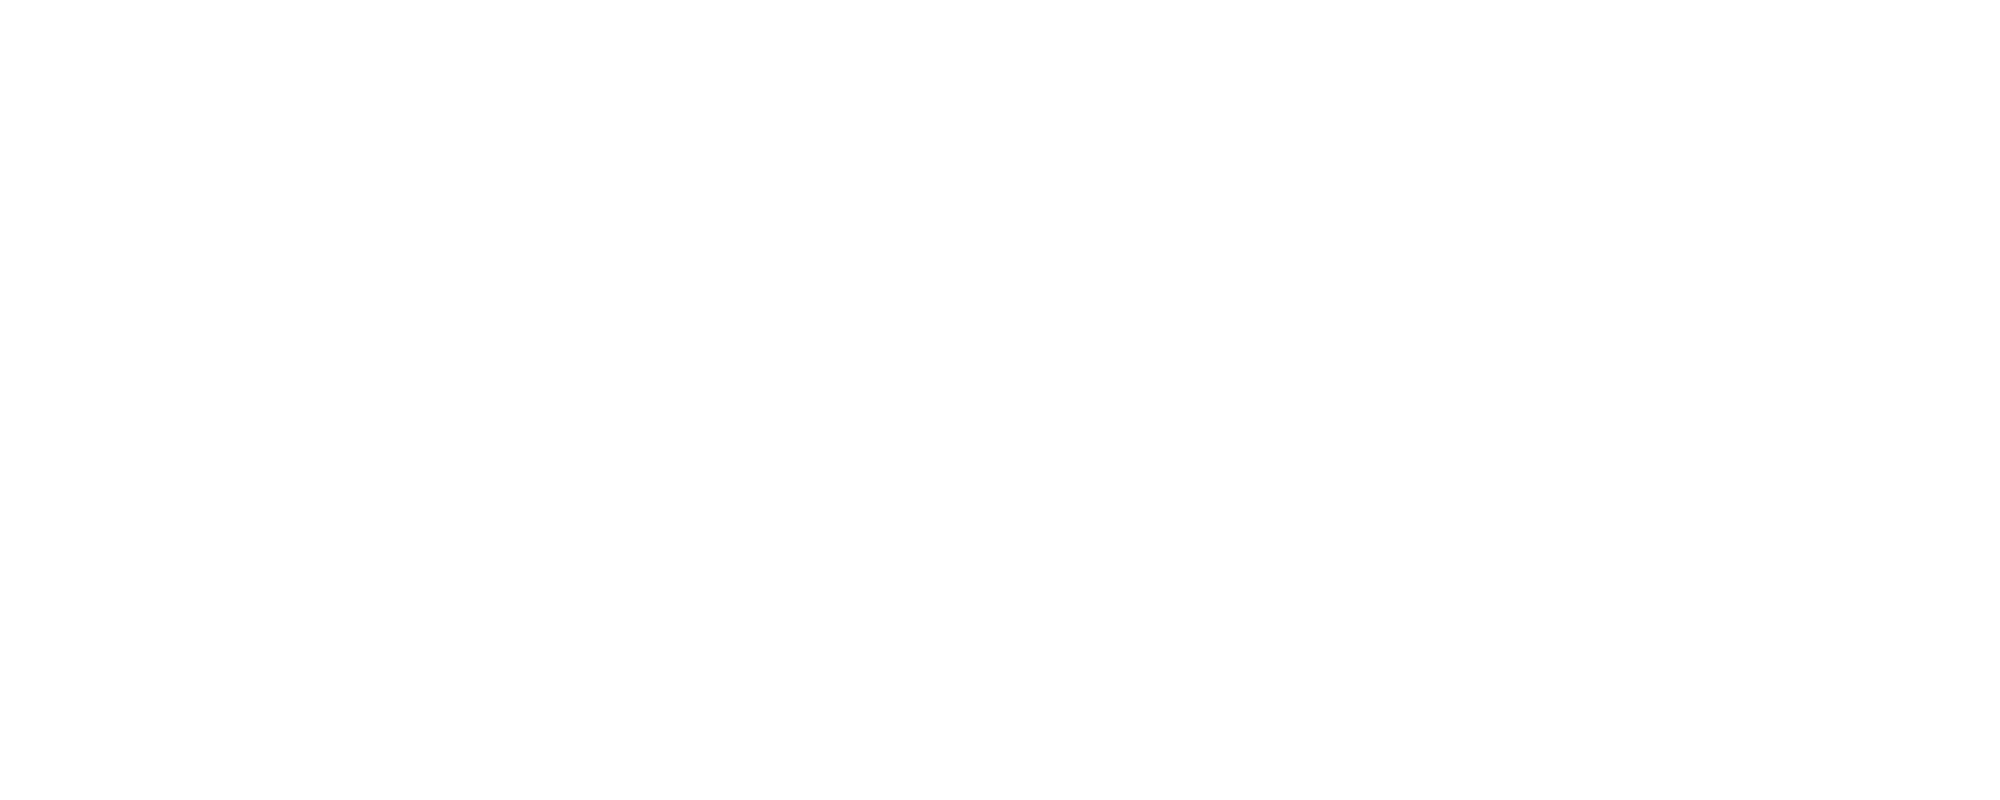

In [39]:
lanes = [(0, 1), (1, 1), (2, -1), (3, -1)]
speed_limit = 5
length_of_street = 50
probability_of_switching_lanes = 0.7
initial_proportion_of_cars = 0.2
do_we_want_traffic_lights = True
time_traffic_lights_are_green_for = 10
time_traffic_lights_are_red_for = 10
current_traffic_light = 'red'
probability_of_slowing_down = 0.5
probability_of_speeding_up = 0.5

street = Street(lanes, speed_limit, length_of_street, probability_of_switching_lanes, initial_proportion_of_cars, do_we_want_traffic_lights, time_traffic_lights_are_green_for, time_traffic_lights_are_red_for, probability_of_slowing_down, probability_of_speeding_up, current_traffic_light)
street.initialize()
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display

##Please note that you will need to download ffmpeg file (in the zip folder) and change the directory appropriately
plt.rcParams['animation.ffmpeg_path'] = '/Users/rhali/Downloads/ffmpeg'

fig = plt.figure(figsize=(10, 4))
ax = plt.gca()
ax.set_yticks([0.5, 2.5], minor=True)
ax.set_yticks([1.5], minor=False)
ax.yaxis.grid(which = 'minor', linewidth = 2, linestyle = '--', color = 'yellow')
ax.yaxis.grid(which = 'major', linewidth = 3, color = 'yellow', linestyle = '-')
anim = FuncAnimation(fig, street.animate, frames=20, interval=200)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

# 2. Making Intersections

In [17]:
class Intersection:
    
    def __init__(self, horizontal_streets, vertical_streets, turn_left_probability, turn_right_probability, pedestrian_probability, cars_per_second, come_from = None):
        
        self.horizontal_streets = horizontal_streets
        self.vertical_streets = vertical_streets
        self.max_speed_limit = max(self.horizontal_streets[0].speed_limit, self.horizontal_streets[1].speed_limit, self.vertical_streets[0].speed_limit, self.vertical_streets[1].speed_limit)
        self.current_state = np.asarray([[-self.max_speed_limit-1]*(self.horizontal_streets[0].length+self.horizontal_streets[1].length+len(self.vertical_streets[0].lanes))]*(self.vertical_streets[0].length+self.vertical_streets[1].length+len(self.horizontal_streets[0].lanes)))
        self.color_map = mpl.cm.RdBu.with_extremes(over = 'black', under = 'yellowgreen')
        self.turn_left_probability = turn_left_probability
        self.turn_right_probability = turn_right_probability
        self.pedestrian_probability = pedestrian_probability
        self.pedestrian = False
        self.cars_leaving_on_the_right = []
        self.cars_leaving_on_the_left = []
        self.come_from = come_from
        self.cars_per_second = cars_per_second
    
    def initialize(self):
        
        self.current_state = np.asarray([[-self.max_speed_limit-1]*(self.horizontal_streets[0].length+self.horizontal_streets[0].length+len(self.vertical_streets[0].lanes))]*(self.vertical_streets[0].length+self.vertical_streets[0].length+len(self.horizontal_streets[0].lanes)))
        
        #fill up the square in the middle of the intersection
        for x in range(self.horizontal_streets[0].length, self.horizontal_streets[0].length+len(self.vertical_streets[0].lanes)):
            for y in range(self.vertical_streets[0].length, self.vertical_streets[0].length+len(self.horizontal_streets[0].lanes)):
                self.current_state[y][x] = self.max_speed_limit+1
        
        #some ugly hard coding to get the streets in place
        for horizontal_lane in range(len(self.horizontal_streets[0].lanes)):
            self.current_state[self.vertical_streets[0].length + horizontal_lane][:self.horizontal_streets[0].length] = self.horizontal_streets[0].current_state[horizontal_lane]
            self.current_state[self.vertical_streets[0].length + horizontal_lane][self.horizontal_streets[0].length+len(self.vertical_streets[0].lanes):self.horizontal_streets[0].length+len(self.vertical_streets[0].lanes)+self.horizontal_streets[1].length] = self.horizontal_streets[1].current_state[horizontal_lane]
            
        for vertical_lane in range(len(self.vertical_streets[0].lanes)):
            for i in range(self.vertical_streets[0].length):
                if self.vertical_streets[0].current_state[vertical_lane][i] == self.vertical_streets[0].speed_limit+1:
                    self.current_state[i][self.horizontal_streets[0].length + vertical_lane] = self.max_speed_limit+1
                else:
                    self.current_state[i][self.horizontal_streets[0].length + vertical_lane] = self.vertical_streets[0].current_state[vertical_lane][i]
            for j in range(self.vertical_streets[0].length+len(self.horizontal_streets[0].lanes), self.vertical_streets[0].length+len(self.vertical_streets[0].lanes)+self.vertical_streets[1].length):
                if self.vertical_streets[1].current_state[vertical_lane][j-self.vertical_streets[0].length-len(self.horizontal_streets[0].lanes)] == self.vertical_streets[1].speed_limit+1:
                    self.current_state[j][self.horizontal_streets[0].length + vertical_lane] = self.max_speed_limit+1
                else:
                    self.current_state[j][self.horizontal_streets[0].length + vertical_lane] = self.vertical_streets[1].current_state[vertical_lane][j-self.vertical_streets[0].length-len(self.horizontal_streets[0].lanes)]
                
    def add_car(self, come_from = None, given_speed = None):
        
        if come_from == None:
            come_from = np.random.choice(['left', 'right', 'top', 'bottom'], 1)[0]
        
        if come_from == 'left':
            chosen_lane = self.horizontal_streets[0].lanes[np.random.randint(len(self.horizontal_streets[0].lanes))]
            
            #keep picking a random lane until it is one going from left to right
            while chosen_lane[1] == -1:
                chosen_lane = self.horizontal_streets[0].lanes[np.random.randint(len(self.horizontal_streets[0].lanes))]
            
            #add a car in that lane
            self.horizontal_streets[0].add_car(lane = chosen_lane, speed = given_speed)
        
        if come_from == 'right':
            chosen_lane = self.horizontal_streets[1].lanes[np.random.randint(len(self.horizontal_streets[1].lanes))]
            
            #keep picking a random lane until it is one going from right to left
            while chosen_lane[1] == 1:
                chosen_lane = self.horizontal_streets[1].lanes[np.random.randint(len(self.horizontal_streets[1].lanes))]
                
            self.horizontal_streets[1].add_car(lane = chosen_lane, speed = given_speed)
        
        if come_from == 'top':
            chosen_lane = self.vertical_streets[0].lanes[np.random.randint(len(self.vertical_streets[0].lanes))]
            
            #keep picking a random lane until it is one going from left to right
            while chosen_lane[1] == -1:
                chosen_lane = self.vertical_streets[0].lanes[np.random.randint(len(self.vertical_streets[0].lanes))]
            
            #add a car in that lane
            self.vertical_streets[0].add_car(lane = chosen_lane, speed = given_speed)
        
        if come_from == 'bottom':
            chosen_lane = self.vertical_streets[1].lanes[np.random.randint(len(self.vertical_streets[1].lanes))]
            
            #keep picking a random lane until it is one going from right to left
            while chosen_lane[1] == 1:
                chosen_lane = self.vertical_streets[1].lanes[np.random.randint(len(self.vertical_streets[1].lanes))]
                
            self.vertical_streets[1].add_car(lane = chosen_lane, speed = given_speed)
    
    def update(self, come_from = None):
            
        self.initialize()
            
        #sometimes cars can't be added because the street is too full!
        for i in range(self.cars_per_second):
            try:
                if come_from == None:
                    self.come_from = np.random.choice(['top', 'bottom', 'left', 'right'])
                else:
                    self.come_from = come_from
                self.add_car(come_from = self.come_from)
        
            except:
                pass
        
        all_streets = [self.horizontal_streets[0], self.horizontal_streets[1], self.vertical_streets[0], self.vertical_streets[1]]
        
        #update every street
        for street in all_streets:
            street.update()
            
        leaving_cars0 = np.asarray(self.horizontal_streets[0].leaving_cars.copy())
        leaving_cars1 = np.asarray(self.horizontal_streets[1].leaving_cars.copy())
        leaving_cars2 = np.asarray(self.vertical_streets[0].leaving_cars.copy())
        leaving_cars3 = np.asarray(self.vertical_streets[1].leaving_cars.copy())

        #update the positions of leaving cars based on the other lanes in the intersection
        #and remove cars that are leaving the street and not joining the intersection
        #and add a 1 to denote cars originally moving horizontally and -1 to denote cars originally moving vertically
        indices = []
        for index, car0 in enumerate(leaving_cars0):
            if car0[1] < 0:
                indices.append(index)

            car0[2] += self.vertical_streets[0].length

        try:
            #save the cars leaving on the left to create a double intersection
            for index in indices:
                self.cars_leaving_on_the_left.append(leaving_cars0[index])
                
            new_leaving_cars0 = np.delete(np.insert(leaving_cars0, 0, 1, axis = 1), indices, 0)

        except:
            new_leaving_cars0 = []

        indices = []
        for index, car1 in enumerate(leaving_cars1):
            if car1[1] >= self.horizontal_streets[1].length-1:
                indices.append(index)

            car1[1] += self.horizontal_streets[0].length + len(self.vertical_streets[0].lanes)
            car1[2] += self.vertical_streets[0].length

        try:
            #save the cars leaving on the right to create a double intersection
            for index in indices:
                self.cars_leaving_on_the_right.append(leaving_cars1[index])

            new_leaving_cars1 = np.delete(np.insert(leaving_cars1, 0, 1, axis = 1), indices, 0)

        except:
            new_leaving_cars1 = []

        indices = []
        for index, car2 in enumerate(leaving_cars2):
            if car2[1] < 0:
                indices.append(index)

            car2[1], car2[2] = car2[2]+self.horizontal_streets[0].length, car2[1]

        try:
            new_leaving_cars2 = np.delete(np.insert(leaving_cars2, 0, -1, axis = 1), indices, 0)

        except:
            new_leaving_cars2 = []

        indices = []
        for index, car3 in enumerate(leaving_cars3):
            if car3[1] >= self.vertical_streets[1].length-1:
                indices.append(index)

            car3[1], car3[2] = car3[2]+self.horizontal_streets[0].length, car3[1]+self.vertical_streets[0].length+len(self.horizontal_streets[0].lanes)

        try:
            new_leaving_cars3 = np.delete(np.insert(leaving_cars3, 0, -1, axis = 1), indices, 0)

        except:
            new_leaving_cars3 = []

        #compile all the leaving cars
        leaving_cars = [new_leaving_cars0, new_leaving_cars1, new_leaving_cars2, new_leaving_cars3]

        #if there are traffic lights
        if self.horizontal_streets[0].lights == True:
            all_leaving_cars = []

            #filtering
            for elem in leaving_cars:

                if len(elem) == 0:
                    continue

                if len(elem) == 1:
                    all_leaving_cars.append(elem[0])

                else:
                    for val in elem:
                        all_leaving_cars.append(val)
        
        #if there are no traffic lights
        elif self.horizontal_streets[0].lights == False:
            waiting_cars = []
            all_leaving_cars = []
            
            #compile all the cars waiting to move at the intersection
            for y in range(len(self.horizontal_streets[0].lanes)):
                if self.horizontal_streets[0].current_state[y][self.horizontal_streets[0].length-1] == 0:
                    random_speed = np.random.randint(1, self.horizontal_streets[0].speed_limit)
                    waiting_cars.append([self.horizontal_streets[0], 1, random_speed, self.horizontal_streets[0].length-1, y])
            
            for y in range(len(self.horizontal_streets[1].lanes)):
                if self.horizontal_streets[1].current_state[y][0] == 0:
                    random_speed = -np.random.randint(1, self.horizontal_streets[1].speed_limit)
                    waiting_cars.append([self.horizontal_streets[1], 1, random_speed, 0, y])
            
            for y in range(len(self.vertical_streets[0].lanes)):
                if self.vertical_streets[0].current_state[y][self.vertical_streets[0].length-1] == 0:
                    random_speed = np.random.randint(1, self.vertical_streets[0].speed_limit)
                    waiting_cars.append([self.vertical_streets[0], -1, random_speed, self.vertical_streets[0].length-1, y])
            
            for y in range(len(self.vertical_streets[1].lanes)):
                if self.vertical_streets[1].current_state[y][0] == 0:
                    random_speed = -np.random.randint(1, self.vertical_streets[1].speed_limit)
                    waiting_cars.append([self.vertical_streets[1], -1, random_speed, 0, y])
            
            #if there are cars waiting
            if len(waiting_cars) > 0:
                
                #if there is a pedestrian
                if np.random.random() < self.pedestrian_probability:
                    
                    #there are four streets and the pedestrian could be at either of the four
                    if np.random.random() < 0.25:
                        self.pedestrian = True
                    
                    else:
                        self.pedestrian = False
                                    
                if self.pedestrian == False:
                    
                    #pick a random car that will move
                    chosen_car = waiting_cars[np.random.randint(0, len(waiting_cars))]
                    
                    #move it to the all_leaving_cars list in the appropriate format
                    if chosen_car[0] == self.horizontal_streets[0]:
                        all_leaving_cars.append([chosen_car[1], chosen_car[2], self.horizontal_streets[0].length + chosen_car[2], chosen_car[4]+self.vertical_streets[0].length])

                    if chosen_car[0] == self.horizontal_streets[1]:
                        all_leaving_cars.append([chosen_car[1], chosen_car[2], self.horizontal_streets[0].length+len(self.vertical_streets[0].lanes)+chosen_car[2], chosen_car[4]+self.vertical_streets[0].length])

                    if chosen_car[0] == self.vertical_streets[0]:
                        all_leaving_cars.append([chosen_car[1], chosen_car[2], chosen_car[4]+self.horizontal_streets[0].length, self.vertical_streets[0].length+chosen_car[2]-1])

                    if chosen_car[0] == self.vertical_streets[1]:
                        all_leaving_cars.append([chosen_car[1], chosen_car[2], chosen_car[4]+self.horizontal_streets[0].length, self.vertical_streets[0].length-1+len(self.horizontal_streets[0].lanes)+chosen_car[2]])

                    chosen_car[0].current_state[chosen_car[4]][chosen_car[3]] = chosen_car[0].speed_limit + 1
                    
                    count = 1
                    
                    #squash all the cars behind the chosen car that aren't moving together
                    for i in range(1, chosen_car[0].length):

                        if chosen_car[0].current_state[chosen_car[4]][chosen_car[3]-i*chosen_car[0].lanes[chosen_car[4]][1]] == 0:
                            chosen_car[0].current_state[chosen_car[4]][chosen_car[3]-(i-count)*chosen_car[0].lanes[chosen_car[4]][1]] = 0
                            chosen_car[0].current_state[chosen_car[4]][chosen_car[3]-i*chosen_car[0].lanes[chosen_car[4]][1]] = chosen_car[0].speed_limit + 1
                            count = 1

                        if chosen_car[0].current_state[chosen_car[4]][chosen_car[3]-i*chosen_car[0].lanes[chosen_car[4]][1]] == chosen_car[0].speed_limit + 1:
                            count+=1
                                    
        #check all the leaving cars and assign them to their appropriate spots in the streets
        for leaving_car in all_leaving_cars: 
            
            #if it is originally moving horizontally
            if leaving_car[0] == 1:
                
                #if it has a positive speed (so if it is coming from the left horizontal lane)
                if leaving_car[1] > 0:
                    
                    if self.horizontal_streets[0].lights == True and self.horizontal_streets[0].traffic_light == 'red':
                        continue
                        
                    #if it is on leftmost edge of the road it can turn left
                    if self.current_state[leaving_car[3] - 1][0] == -self.max_speed_limit-1:
                        
                        if np.random.random() < self.turn_left_probability:
                            #for simplicity we will assume that cars speed up/slow down to turn in one time step.
                            #it will now be in the top vertical street's right most lane
                            
                            #if it can turn in that lane
                            if self.vertical_streets[0].lanes[len(self.vertical_streets[0].lanes)-1][1] == -1:
                                self.vertical_streets[0].add_car(lane = (len(self.vertical_streets[0].lanes)-1, -1), speed = -leaving_car[1])
                            
                            #or else it keeps going straight
                            else:
                                #it will now be in the horizontal street on the right 
                                self.horizontal_streets[1].add_car(lane = (leaving_car[3] - self.vertical_streets[0].length, 1), speed = leaving_car[1])
                                
                        #or else it keeps going straight
                        else:
                            self.horizontal_streets[1].add_car(lane = (leaving_car[3] - self.vertical_streets[0].length, 1), speed = leaving_car[1])
                    
                    #if it is on the rightmost edge of the lanes moving in its direction it can turn right
                    elif self.current_state[leaving_car[3] + 1][0] == -self.max_speed_limit-1 or self.horizontal_streets[0].lanes[leaving_car[3] - self.vertical_streets[0].length + 1][1] == -1:
                        
                        if np.random.random() < self.turn_right_probability:
                            #it will not be on the bottom vertical street's leftmost lane
                            #if it can turn right
                            if self.vertical_streets[1].lanes[len(self.vertical_streets[0].lanes)-1][1] == 1:
                                self.vertical_streets[1].add_car(lane = (len(self.vertical_streets[0].lanes)-1, 1), speed = leaving_car[1])
                            
                            #or else it keeps going straight
                            else:
                                #it will not be in the horizontal street on the right
                                self.horizontal_streets[1].add_car(lane = (leaving_car[3] - self.vertical_streets[0].length, 1), speed = leaving_car[1])
                        
                        #or else it keeps going straight
                        else:
                            self.horizontal_streets[1].add_car(lane = (leaving_car[3] - self.vertical_streets[0].length, 1), speed = leaving_car[1])
                            
                    #or else it keeps going straight
                    else:
                        #it will now be in the horizontal street on the right
                        self.horizontal_streets[1].add_car(lane = (leaving_car[3] - self.vertical_streets[0].length, 1), speed = leaving_car[1])
                
                #if it has a negative speed (so if it is coming from the right horizontal lane)
                if leaving_car[1] < 0:
                    
                    if self.horizontal_streets[1].lights == True and self.horizontal_streets[1].traffic_light == 'red':
                        continue
                    
                    #if it is on leftmost edge of the road it can turn left
                    if self.current_state[leaving_car[3] + 1][0] == self.max_speed_limit+1:
                        
                        if np.random.random() < self.turn_left_probability:
                            #it will now be on the bottom vertical lane
                            #if it can turn left
                            if self.vertical_streets[1].lanes[len(self.vertical_streets[0].lanes)-1][1] == 1:
                                self.vertical_streets[1].add_car(lane = (len(self.vertical_streets[0].lanes)-1, 1), speed = -leaving_car[1])
                            
                            #or else it will keep going straight
                            else:
                                self.horizontal_streets[0].add_car(lane = (leaving_car[3] - self.vertical_streets[0].length, -1), speed = leaving_car[1])
                                
                        #or else it keeps going straight
                        else:
                            self.horizontal_streets[0].add_car(lane = (leaving_car[3] - self.vertical_streets[0].length, -1), speed = leaving_car[1])
                    
                    #if it is on the rightmost edge of the street moving in the same direction it can turn right
                    elif self.current_state[leaving_car[3] - 1][0] == self.max_speed_limit+1 or self.horizontal_streets[1].lanes[leaving_car[3] - self.vertical_streets[0].length - 1][1] == 1:
                        
                        if np.random.random() < self.turn_right_probability:
                            
                            #if it can turn right
                            if self.vertical_streets[0].lanes[0][1] == 1:
                                self.vertical_streets[0].add_car(lane = (0, 1), speed = leaving_car[1])
                            
                            #or else it keeps going straight
                            else:
                                self.horizontal_streets[1].add_car(lane = (leaving_car[3] - self.vertical_streets[0].length, -1), speed = leaving_car[1])
                        
                        #or else it keeps going straight
                        else:
                            self.horizontal_streets[1].add_car(lane = (leaving_car[3] - self.vertical_streets[0].length, -1), speed = leaving_car[1])
                    
                    #or else it keeps going straight
                    else:
                        self.horizontal_streets[0].add_car(lane = (leaving_car[3] - self.vertical_streets[0].length, -1), speed = leaving_car[1])
            
            #if it is moving vertically
            if leaving_car[0] == -1:
                #if it has a negative speed (so if it is coming from the bottom vertical lane)
                if leaving_car[1] < 0:
                    
                    if self.vertical_streets[0].lights == True and self.vertical_streets[0].traffic_light == 'red':
                        continue
                    
                    #if it is on leftmost edge of the road it can turn left
                    if self.current_state[leaving_car[2] - 1][0] == self.max_speed_limit+1:
                        
                        if np.random.random() < self.turn_left_probability:
                            
                            #if it can turn left
                            if self.horizontal_streets[0].lanes[len(self.horizontal_streets[0].lanes)-1][1] == -1:
                                self.horizontal_streets[0].add_car(lane = (len(self.horizontal_streets[0].lanes)-1, -1), speed = leaving_car[1])
                            
                            #or else it keeps going straight
                            else:
                                self.vertical_streets[0].add_car(lane = (leaving_car[2] - self.horizontal_streets[0].length, -1), speed = leaving_car[1])

                        #or else it keeps going straight
                        else:
                            self.vertical_streets[0].add_car(lane = (leaving_car[2] - self.horizontal_streets[0].length, -1), speed = leaving_car[1])
                    
                    #sometimes the car is at the end of the lane so we need to account for the potential error
                    dummy = False
                    try:
                        if self.vertical_streets[0].lanes[leaving_car[2] - self.horizontal_streets[0].length + 1][1] == 1:
                            dummy = True
                    except:
                        pass
                        
                    #if it is on the rightmost edge of the street moving in the same direction it can turn right
                    if self.current_state[0][leaving_car[2] + 1] == -self.max_speed_limit-1 or dummy:
                        
                        if np.random.random() < self.turn_right_probability:
                            
                            #if it can turn right
                            if self.horizontal_streets[1].lanes[0][1] == 1:
                                self.horizontal_streets[1].add_car(lane = (0, 1), speed = -leaving_car[1])
                            
                            #or else it keeps going straight
                            else:
                                self.vertical_streets[0].add_car(lane = (leaving_car[2] - self.horizontal_streets[0].length, -1), speed = leaving_car[1])
                                
                        #or else it keeps going straight
                        else:
                            self.vertical_streets[0].add_car(lane = (leaving_car[2] - self.horizontal_streets[0].length, -1), speed = leaving_car[1])
                    
                    #or else it keeps going straight
                    else:
                        self.vertical_streets[0].add_car(lane = (leaving_car[2] - self.horizontal_streets[0].length, -1), speed = leaving_car[1])
                
                #if it has a positive speed (so if it is coming from the top vertical lane)
                if leaving_car[1] > 0:
                    
                    if self.vertical_streets[1].lights == True and self.vertical_streets[1].traffic_light == 'red':
                        continue
                    
                    #if it is on the leftmost edge of the road it can turn left
                    if self.current_state[0][leaving_car[2] + 1] == -self.max_speed_limit-1:
                        
                        if np.random.random() < self.turn_left_probability:
                            
                            #if it can turn left
                            if self.horizontal_streets[1].lanes[0][1] == 1:
                                self.horizontal_streets[1].add_car(lane = (0, 1), speed = leaving_car[1])
                            
                            #or else it keeps going straight
                            else:
                                self.vertical_streets[1].add_car(lane = (leaving_car[2] - self.horizontal_streets[0].length, 1), speed = leaving_car[1])
                                
                        #or else it keeps going straight
                        else:
                            self.vertical_streets[1].add_car(lane = (leaving_car[2] - self.horizontal_streets[0].length, 1), speed = leaving_car[1])
                    
                    #if it is on the rightmost edge of the street moving in the same direction it can turn right
                    elif self.current_state[0][leaving_car[2] - 1] == -self.max_speed_limit-1 or self.vertical_streets[1].lanes[leaving_car[2] - self.horizontal_streets[0].length - 1][1] == -1:
                        if np.random.random() < self.turn_right_probability:
                            
                            #if it can turn right
                            if self.horizontal_streets[0].lanes[len(self.horizontal_streets[0].lanes)-1][1] == -1:
                                self.horizontal_streets[0].add_car(lane = (len(self.horizontal_streets[0].lanes)-1, -1), speed = -leaving_car[1])
                            
                            #or else it keeps going straight
                            else:
                                self.vertical_streets[1].add_car(lane = (leaving_car[2] - self.horizontal_streets[0].length, 1), speed = leaving_car[1])

                        #or else it keeps going straight
                        else:
                            self.vertical_streets[1].add_car(lane = (leaving_car[2] - self.horizontal_streets[0].length, 1), speed = leaving_car[1])
                    
                    #or else it keeps going straight
                    else:
                        self.vertical_streets[1].add_car(lane = (leaving_car[2] - self.horizontal_streets[0].length, 1), speed = leaving_car[1])

    def observe(self):
        matplotlib.pyplot.imshow(self.current_state, vmin = -self.max_speed_limit, vmax = self.max_speed_limit, cmap = self.color_map)
        
        #showing the traffic lights
        if self.horizontal_streets[0].lights == True:
            for lane in self.horizontal_streets[0].lanes:
                if lane[1] == 1:
                    matplotlib.pyplot.plot([self.horizontal_streets[0].length-0.5, self.horizontal_streets[0].length-0.5], [lane[0]+self.vertical_streets[0].length-0.5, lane[0]+self.vertical_streets[0].length + 0.5], color = self.horizontal_streets[0].traffic_light, linewidth = 3)    

            for lane in self.horizontal_streets[1].lanes:
                if lane[1] == -1:
                    matplotlib.pyplot.plot([self.horizontal_streets[0].length+len(self.vertical_streets[0].lanes)-0.5, self.horizontal_streets[0].length+len(self.vertical_streets[0].lanes)-0.5], [lane[0]+self.vertical_streets[0].length-0.5, lane[0]+self.vertical_streets[0].length + 0.5], color = self.horizontal_streets[1].traffic_light, linewidth = 3)    

            for lane in self.vertical_streets[0].lanes:
                if lane[1] == 1:
                    matplotlib.pyplot.plot([lane[0]+self.horizontal_streets[0].length-0.5, lane[0]+self.horizontal_streets[0].length + 0.5], [self.vertical_streets[0].length-0.5, self.vertical_streets[0].length-0.5], color = self.vertical_streets[0].traffic_light, linewidth = 3)    

            for lane in self.vertical_streets[1].lanes:
                if lane[1] == -1:
                    matplotlib.pyplot.plot([lane[0]+self.horizontal_streets[0].length-0.5, lane[0]+self.horizontal_streets[0].length + 0.5], [self.vertical_streets[0].length+len(self.horizontal_streets[0].lanes)-0.5, self.vertical_streets[0].length+len(self.horizontal_streets[0].lanes)-0.5], color = self.vertical_streets[1].traffic_light, linewidth = 3)    
        
        if self.pedestrian == True:
            matplotlib.pyplot.text(x = self.horizontal_streets[0].length, y = self.vertical_streets[0].length+int(0.5*len(self.horizontal_streets[0].lanes)), s = 'ah!', color = 'black', backgroundcolor = 'red', zorder = 1)
        
        if self.pedestrian == False:
            matplotlib.pyplot.text(x = self.horizontal_streets[0].length, y = self.vertical_streets[0].length+int(0.5*len(self.horizontal_streets[0].lanes)), s = 'ah!', color = 'black', backgroundcolor = 'black', zorder = 1)
        
    def animate(self, i):
        self.observe()
        self.update()
            
        return matplotlib.pyplot.show()

<IPython.core.display.Javascript object>


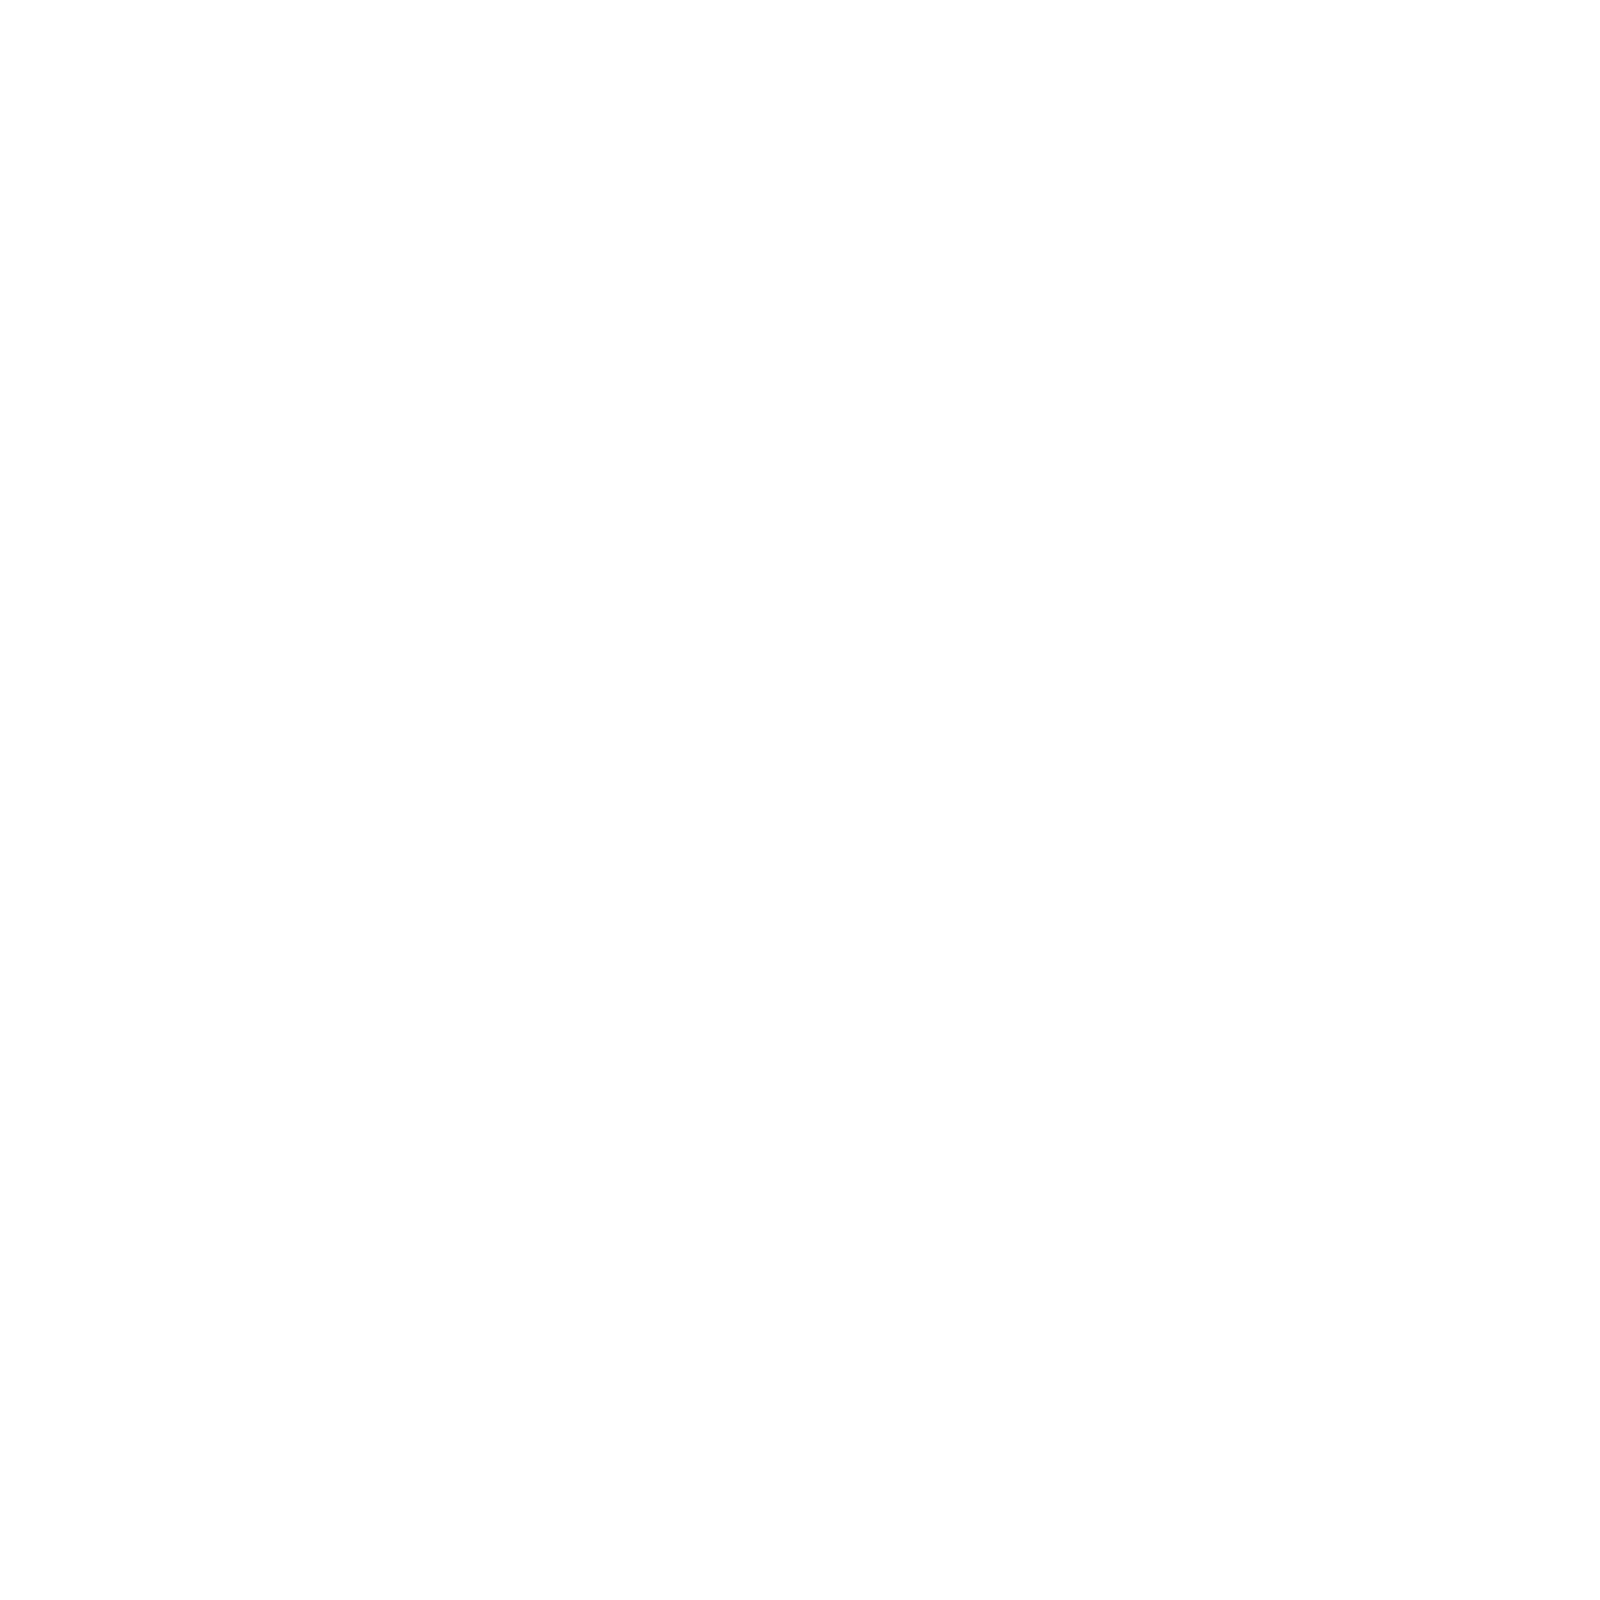

In [18]:
street = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 20, 20, 0.2, 0.2, True, 5, 10, 0.1, 0.1, 'red')
street1 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 20, 20, 0.2, 0.2, True, 5, 10, 0.1, 0.1, 'red')
street2 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 20, 20, 0.2, 0.2, True, 10, 5, 0.1, 0.1, 'green')
street3 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 20, 20, 0.2, 0.2, True, 10, 5, 0.1, 0.1, 'green')

horizontal_streets = (street, street1)
vertical_streets = (street2, street3)
probability_of_turning_left_at_intersection = 0.5
probability_of_turning_right_at_intersection = 0.5
probability_of_pedestrians = 0.7
cars_added_per_second = 2
cars_can_come_from = 'top'

intersection = Intersection(horizontal_streets, vertical_streets, probability_of_turning_left_at_intersection, probability_of_turning_right_at_intersection, probability_of_pedestrians, cars_added_per_second, cars_can_come_from)

%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from IPython import display

##Please note that you will need to download ffmpeg file (in the zip folder) and change the directory appropriately
plt.rcParams['animation.ffmpeg_path'] = '/Users/rhali/Downloads/ffmpeg'

fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.plot([0, 19], [20.5, 20.5], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([22+2, 41+2], [20.5, 20.5], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([0, 19], [21.5, 21.5], linestyle = '-', linewidth = 3, color = 'yellow')
ax.plot([22+2, 41+2], [21.5, 21.5], linestyle = '-', linewidth = 3, color = 'yellow')
ax.plot([0, 19], [22.5, 22.5], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([22+2, 41+2], [22.5, 22.5], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([20.5, 20.5], [0, 19], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([22.5, 22.5], [0, 19], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([21.5, 21.5], [0, 19], linestyle = '-', linewidth = 3, color = 'yellow')
ax.plot([20.5, 20.5], [24, 41+2], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([22.5, 22.5], [24, 41+2], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([21.5, 21.5], [24, 41+2], linestyle = '-', linewidth = 3, color = 'yellow')

anim = FuncAnimation(fig, intersection.animate, frames=40, interval=200)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

# 3. Making our double intersection

In [19]:
class My_double_intersection:

    def __init__(self, intersections):
        self.intersections = intersections
        self.current_state = np.asarray([[-self.intersections[0].max_speed_limit-1]*(len(self.intersections[0].current_state[0])+len(self.intersections[1].current_state[0]))]*(len(self.intersections[0].current_state)))
        self.average_traffic_flow = []
    
    def initialize(self):
        for y in range(len(self.intersections[0].current_state)):
            for x1 in range(len(self.intersections[0].current_state[0])):
                self.current_state[y][x1] = self.intersections[0].current_state[y][x1]
            for x2 in range(len(self.intersections[1].current_state[0])):
                self.current_state[y][x2+len(self.intersections[0].current_state[0])] = self.intersections[1].current_state[y][x2]
    
    def find_average_traffic_flow(self):
        
        summing = 0
        total = 0
        
        #summing up all cells with cars into summing and all cells with a road into total
        for y in range(len(self.current_state)):
            for x in range(len(self.current_state[0])):
                if self.current_state[y][x] >= -self.intersections[0].max_speed_limit:
                    total += 1
                if self.current_state[y][x] >= -self.intersections[0].max_speed_limit and self.current_state[y][x] <= self.intersections[0].max_speed_limit:
                    summing += 1
        
        return summing/total
        
    def observe(self):
        matplotlib.pyplot.imshow(self.current_state[:- 2], vmin = -self.intersections[0].max_speed_limit, vmax = self.intersections[0].max_speed_limit, cmap = self.intersections[0].color_map)
        
        #showing the traffic lights for the first intersection
        if self.intersections[0].horizontal_streets[0].lights == True:
            for lane in self.intersections[0].horizontal_streets[0].lanes:
                if lane[1] == 1:
                    matplotlib.pyplot.plot([self.intersections[0].horizontal_streets[0].length-0.5, self.intersections[0].horizontal_streets[0].length-0.5], [lane[0]+self.intersections[0].vertical_streets[0].length-0.5, lane[0]+self.intersections[0].vertical_streets[0].length + 0.5], color = self.intersections[0].horizontal_streets[0].traffic_light, linewidth = 3)    

            for lane in self.intersections[0].horizontal_streets[1].lanes:
                if lane[1] == -1:
                    matplotlib.pyplot.plot([self.intersections[0].horizontal_streets[0].length+len(self.intersections[0].vertical_streets[0].lanes)-0.5, self.intersections[0].horizontal_streets[0].length+len(self.intersections[0].vertical_streets[0].lanes)-0.5], [lane[0]+self.intersections[0].vertical_streets[0].length-0.5, lane[0]+self.intersections[0].vertical_streets[0].length + 0.5], color = self.intersections[0].horizontal_streets[1].traffic_light, linewidth = 3)    

            for lane in self.intersections[0].vertical_streets[0].lanes:
                if lane[1] == 1:
                    matplotlib.pyplot.plot([lane[0]+self.intersections[0].horizontal_streets[0].length-0.5, lane[0]+self.intersections[0].horizontal_streets[0].length + 0.5], [self.intersections[0].vertical_streets[0].length-0.5, self.intersections[0].vertical_streets[0].length-0.5], color = self.intersections[0].vertical_streets[0].traffic_light, linewidth = 3)    

            for lane in self.intersections[0].vertical_streets[1].lanes:
                if lane[1] == -1:
                    matplotlib.pyplot.plot([lane[0]+self.intersections[0].horizontal_streets[0].length-0.5, lane[0]+self.intersections[0].horizontal_streets[0].length + 0.5], [self.intersections[0].vertical_streets[0].length+len(self.intersections[0].horizontal_streets[0].lanes)-0.5, self.intersections[0].vertical_streets[0].length+len(self.intersections[0].horizontal_streets[0].lanes)-0.5], color = self.intersections[0].vertical_streets[1].traffic_light, linewidth = 3)    
        
        #showing the pedestrian for the first intersection
        if self.intersections[0].horizontal_streets[0].lights == False:
            if self.intersections[0].pedestrian == True:
                matplotlib.pyplot.text(x = self.intersections[0].horizontal_streets[0].length, y = self.intersections[0].vertical_streets[0].length+int(0.5*len(self.intersections[0].horizontal_streets[0].lanes)), s = 'ah!', color = 'black', backgroundcolor = 'red', zorder = 1)

            if self.intersections[0].pedestrian == False:
                matplotlib.pyplot.text(x = self.intersections[0].horizontal_streets[0].length, y = self.intersections[0].vertical_streets[0].length+int(0.5*len(self.intersections[0].horizontal_streets[0].lanes)), s = 'ah!', color = 'black', backgroundcolor = 'black', zorder = 1)
        
        #showing the traffic lights for the second intersection
        if self.intersections[1].horizontal_streets[1].lights == True:
            for lane in self.intersections[1].horizontal_streets[0].lanes:
                if lane[1] == 1:
                    matplotlib.pyplot.plot([len(self.intersections[0].current_state[0]) + self.intersections[1].horizontal_streets[0].length-0.5, len(self.intersections[0].current_state[0]) +self.intersections[1].horizontal_streets[0].length-0.5], [lane[0]+self.intersections[1].vertical_streets[0].length-0.5, lane[0]+self.intersections[1].vertical_streets[0].length + 0.5], color = self.intersections[1].horizontal_streets[0].traffic_light, linewidth = 3)    

            for lane in self.intersections[1].horizontal_streets[1].lanes:
                if lane[1] == -1:
                    matplotlib.pyplot.plot([len(self.intersections[0].current_state[0]) +self.intersections[1].horizontal_streets[0].length+len(self.intersections[1].vertical_streets[0].lanes)-0.5, len(self.intersections[0].current_state[0]) +self.intersections[1].horizontal_streets[0].length+len(self.intersections[1].vertical_streets[0].lanes)-0.5], [lane[0]+self.intersections[1].vertical_streets[0].length-0.5, lane[0]+self.intersections[1].vertical_streets[0].length + 0.5], color = self.intersections[1].horizontal_streets[1].traffic_light, linewidth = 3)    

            for lane in self.intersections[1].vertical_streets[0].lanes:
                if lane[1] == 1:
                    matplotlib.pyplot.plot([len(self.intersections[0].current_state[0]) +lane[0]+self.intersections[1].horizontal_streets[0].length-0.5, len(self.intersections[0].current_state[0]) +lane[0]+self.intersections[1].horizontal_streets[0].length + 0.5], [self.intersections[1].vertical_streets[0].length-0.5, self.intersections[1].vertical_streets[0].length-0.5], color = self.intersections[1].vertical_streets[0].traffic_light, linewidth = 3)    

            for lane in self.intersections[1].vertical_streets[1].lanes:
                if lane[1] == -1:
                    matplotlib.pyplot.plot([len(self.intersections[0].current_state[0]) +lane[0]+self.intersections[1].horizontal_streets[0].length-0.5, len(self.intersections[0].current_state[0]) +lane[0]+self.intersections[1].horizontal_streets[0].length + 0.5], [self.intersections[1].vertical_streets[0].length+len(self.intersections[1].horizontal_streets[0].lanes)-0.5, self.intersections[1].vertical_streets[0].length+len(self.intersections[1].horizontal_streets[0].lanes)-0.5], color = self.intersections[1].vertical_streets[1].traffic_light, linewidth = 3)    
        
        if self.intersections[1].horizontal_streets[1].lights == False:
            #showing the pedestrian for the second intersection
            if self.intersections[1].pedestrian == True:
                matplotlib.pyplot.text(x = len(self.intersections[0].current_state[0]) +self.intersections[1].horizontal_streets[0].length, y = self.intersections[1].vertical_streets[0].length+int(0.5*len(self.intersections[1].horizontal_streets[0].lanes)), s = 'ah!', color = 'black', backgroundcolor = 'red', zorder = 1)

            if self.intersections[1].pedestrian == False:
                matplotlib.pyplot.text(x = len(self.intersections[0].current_state[0]) +self.intersections[1].horizontal_streets[0].length, y = self.intersections[1].vertical_streets[0].length+int(0.5*len(self.intersections[1].horizontal_streets[0].lanes)), s = 'ah!', color = 'black', backgroundcolor = 'black', zorder = 1)
        
    def update(self):
        #higher probability that cars come from the main road than the small roads
        self.intersections[0].update(come_from = np.random.choice(['top', 'left'], 1, p = [1/3, 2/3])[0])
        self.intersections[1].update(come_from = np.random.choice(['bottom', 'right'], 1, p = [1/3, 2/3])[0])
        
        #feed appropriate cars leaving one intersection class into the other intersection class
        while self.intersections[0].cars_leaving_on_the_right:
            self.intersections[1].add_car(come_from = 'left', given_speed = self.intersections[0].cars_leaving_on_the_right[0][0])
            self.intersections[0].cars_leaving_on_the_right.pop(0)
        while self.intersections[1].cars_leaving_on_the_left:
            self.intersections[0].add_car(come_from = 'right', given_speed = self.intersections[1].cars_leaving_on_the_left[0][0])
            self.intersections[1].cars_leaving_on_the_left.pop(0)
        
        #remove cars that are leaving the intersections (only for the case where there are no traffic lights)
        if self.intersections[0].horizontal_streets[0].lights == False:
            for y in range(2, 4):
                for x in range(self.intersections[0].horizontal_streets[0].length):
                    if self.intersections[0].horizontal_streets[0].current_state[y][x] == 0:
                        self.intersections[0].horizontal_streets[0].current_state[y][x] = self.intersections[0].max_speed_limit + 1
                for x in range(self.intersections[0].vertical_streets[0].length):
                    if self.intersections[0].vertical_streets[1].current_state[y-2][x] == 0:
                        self.intersections[0].vertical_streets[1].current_state[y-2][x] = self.intersections[0].max_speed_limit + 1
        
        #remove cars that are leaving the intersections (only for the case where there are no traffic lights)
        if self.intersections[1].horizontal_streets[1].lights == False:
            for y in range(0, 2):
                for x in range(self.intersections[1].vertical_streets[1].length):
                    if self.intersections[1].vertical_streets[0].current_state[y][x] == 0:
                        self.intersections[1].vertical_streets[0].current_state[y][x] = self.intersections[0].max_speed_limit + 1
                for x in range(self.intersections[1].horizontal_streets[1].length):
                    if self.intersections[1].horizontal_streets[1].current_state[y][x] == 0:
                        self.intersections[1].horizontal_streets[1].current_state[y][x] = self.intersections[0].max_speed_limit + 1

        self.initialize()
        self.average_traffic_flow.append(self.find_average_traffic_flow())
        
    def animate(self, i):
        self.observe()
        self.update()

        return matplotlib.pyplot.show()

<IPython.core.display.Javascript object>


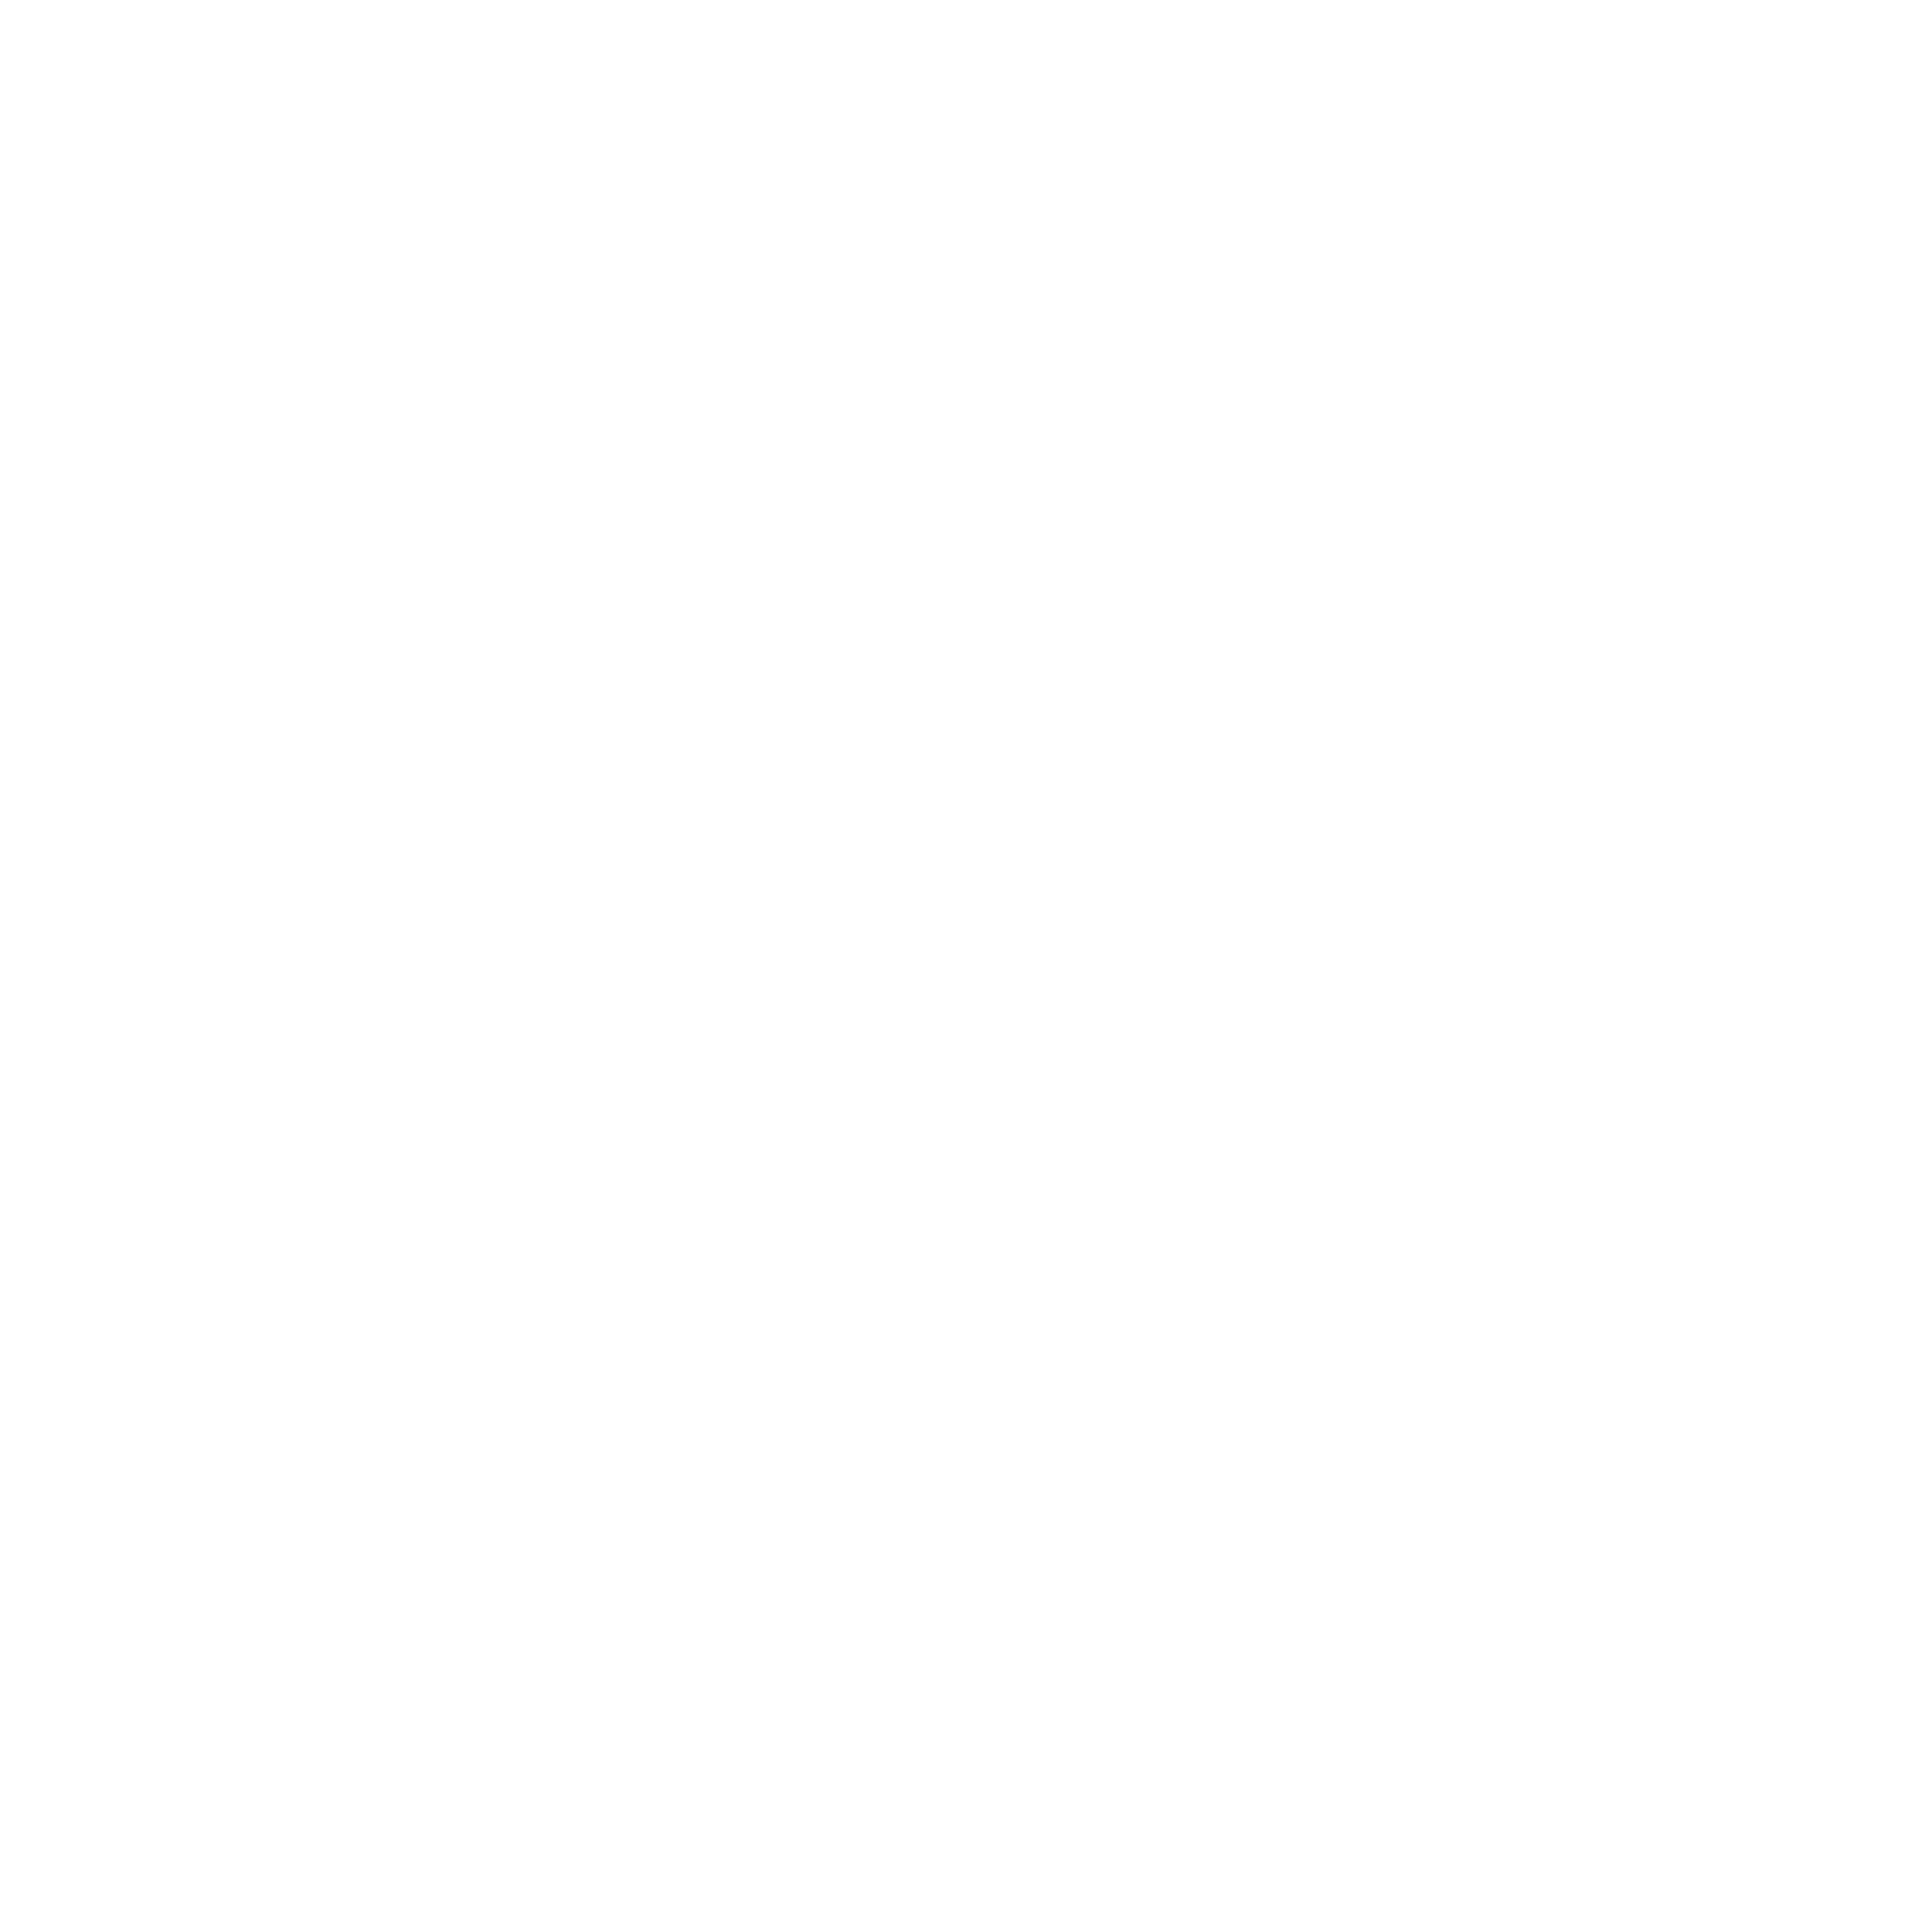

In [38]:
street0 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0, True, 55, 40, 0.1, 0.1, 'red')
street1 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0, True, 55, 40, 0.1, 0.1, 'red', end = False, where = 1)
street2 = Street([(0, 1), (1, 1)], 5, 10, 0.2, 0, True, 40, 55, 0.1, 0.1, 'green')
street3 = Street([(0, 1), (1, 1)], 5, 10, 0.2, 0, True, 40, 55, 0.1, 0.1, 'green')
intersection0 = Intersection((street0, street1), (street2, street3), 0.1, 0.115, 0.243, 1)

street00 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0.2, False, 55, 40, 0.1, 0.1, 'green', end = False, where = -1)
street11 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0.2, False, 55, 40, 0.1, 0.1, 'green')
street22 = Street([(0, -1), (1, -1)], 5, 10, 0.2, 0.2, False, 40, 55, 0.1, 0.1, 'red')
street33 = Street([(0, -1), (1, -1)], 5, 10, 0.2, 0.2, False, 55, 55, 0.1, 0.1, 'red')
intersection1 = Intersection((street00, street11), (street22, street33), 0.11, 0.105, 0.38, 1)

my_double_intersection = My_double_intersection([intersection0, intersection1])
my_double_intersection.initialize()
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from IPython import display

##Please note that you will need to download ffmpeg file (in the zip folder) and change the directory appropriately
plt.rcParams['animation.ffmpeg_path'] = '/Users/rhali/Downloads/ffmpeg'

fig = plt.figure(figsize=(12, 12))
ax = plt.gca()

#horizontal yellow lines
ax.plot([0, 21], [10.5, 10.5], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([0, 21], [11.5, 11.5], linestyle = '-', linewidth = 3, color = 'yellow')
ax.plot([0, 21], [12.5, 12.5], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([24, 67], [10.5, 10.5], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([24, 67], [11.5, 11.5], linestyle = '-', linewidth = 3, color = 'yellow')
ax.plot([24, 67], [12.5, 12.5], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([70, 91], [10.5, 10.5], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([70, 91], [11.5, 11.5], linestyle = '-', linewidth = 3, color = 'yellow')
ax.plot([70, 91], [12.5, 12.5], linestyle = '--', linewidth = 2, color = 'yellow')

#vertical yellow lines
ax.plot([22.5, 22.5], [0, 9.5], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([22.5, 22.5], [13.5, 21], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([68.5, 68.5], [0, 9.5], linestyle = '--', linewidth = 2, color = 'yellow')
ax.plot([68.5, 68.5], [13.5, 21], linestyle = '--', linewidth = 2, color = 'yellow')

anim = FuncAnimation(fig, my_double_intersection.animate, frames=80, interval=200)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

# 4. Getting results

## 4.1 Traffic lights on both intersections

In [ ]:
from tqdm import tqdm
street0 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0, True, 55, 40, 0.1, 0.1, 'red')
street1 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0, True, 55, 40, 0.1, 0.1, 'red', end = False, where = 1)
street2 = Street([(0, 1), (1, 1)], 5, 10, 0.2, 0, True, 40, 55, 0.1, 0.1, 'green')
street3 = Street([(0, 1), (1, 1)], 5, 10, 0.2, 0, True, 40, 55, 0.1, 0.1, 'green')
intersection0 = Intersection((street0, street1), (street2, street3), 0.1, 0.115, 0.243)

street00 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0.2, True, 55, 40, 0.1, 0.1, 'green', end = False, where = -1)
street11 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0.2, True, 55, 40, 0.1, 0.1, 'green')
street22 = Street([(0, -1), (1, -1)], 5, 10, 0.2, 0.2, True, 40, 55, 0.1, 0.1, 'red')
street33 = Street([(0, -1), (1, -1)], 5, 10, 0.2, 0.2, True, 40, 55, 0.1, 0.1, 'red')
intersection1 = Intersection((street00, street11), (street22, street33), 0.11, 0.105, 0.38)

my_double_intersection = My_double_intersection([intersection0, intersection1])
my_double_intersection.initialize()

x = []
flow = []
for i in tqdm(range(1000)):
    my_double_intersection.update()
    x.append(i)
flow = my_double_intersection.average_traffic_flow

traffic_flow = []
for i in tqdm(range(100)):
    my_double_intersection = My_double_intersection([intersection0, intersection1])
    my_double_intersection.initialize()
    for j in range(200):
        my_double_intersection.update()
    traffic_flow.append(my_double_intersection.average_traffic_flow[-1])  

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.plot(x, flow, color = 'black')
plt.xlabel('Steps')
plt.ylabel('Average traffic flow')

In [ ]:
%matplotlib notebook
confidence_interval = np.linspace(np.mean(traffic_flow) - 1.96*np.std(traffic_flow)/10, np.mean(traffic_flow) + 1.96*np.std(traffic_flow)/10, 1000)
plt.hist(traffic_flow, density = True, color = 'black')
plt.plot([np.mean(traffic_flow), np.mean(traffic_flow)], [0, 19.3], color = 'mediumpurple', label = 'mean')
plt.fill_between(confidence_interval, 19.3, color = 'mediumpurple', alpha = 0.5, label = '95% confidence interval')
plt.xlabel('Average traffic flow')
plt.ylabel('Probability density')
plt.legend(fontsize = 'small', loc = 2)

## 4.2 Traffic lights only on Gorriti

In [ ]:
street0 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0, True, 55, 40, 0.1, 0.1, 'red')
street1 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0, True, 55, 40, 0.1, 0.1, 'red', end = False, where = 1)
street2 = Street([(0, 1), (1, 1)], 5, 10, 0.2, 0, True, 40, 55, 0.1, 0.1, 'green')
street3 = Street([(0, 1), (1, 1)], 5, 10, 0.2, 0, True, 40, 55, 0.1, 0.1, 'green')
intersection0 = Intersection((street0, street1), (street2, street3), 0.1, 0.115, 0.243)

street00 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0.2, False, 55, 40, 0.1, 0.1, 'green', end = False, where = -1)
street11 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0.2, False, 55, 40, 0.1, 0.1, 'green')
street22 = Street([(0, -1), (1, -1)], 5, 10, 0.2, 0.2, False, 40, 55, 0.1, 0.1, 'red')
street33 = Street([(0, -1), (1, -1)], 5, 10, 0.2, 0.2, False, 40, 55, 0.1, 0.1, 'red')
intersection1 = Intersection((street00, street11), (street22, street33), 0.11, 0.105, 0.38)

my_double_intersection = My_double_intersection([intersection0, intersection1])
my_double_intersection.initialize()

x = []

for i in tqdm(range(1000)):
    my_double_intersection.update()
    x.append(i)

    flow2 = my_double_intersection.average_traffic_flow

traffic_flow2 = []
for i in tqdm(range(100)):
    my_double_intersection = My_double_intersection([intersection0, intersection1])
    my_double_intersection.initialize()
    for j in range(200):
        my_double_intersection.update()
    traffic_flow2.append(my_double_intersection.average_traffic_flow[-1])  

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.plot(x, flow2, color = 'black')
plt.xlabel('Steps')
plt.ylabel('Average traffic flow')

In [ ]:
%matplotlib notebook
confidence_interval = np.linspace(np.mean(traffic_flow2) - 1.96*np.std(traffic_flow2)/10, np.mean(traffic_flow2) + 1.96*np.std(traffic_flow2)/10, 1000)
plt.hist(traffic_flow2, density = True, color = 'black')
plt.plot([np.mean(traffic_flow2), np.mean(traffic_flow2)], [0, 21.5], color = 'mediumpurple', label = 'mean')
plt.fill_between(confidence_interval, 21.5, color = 'mediumpurple', alpha = 0.5, label = '95% confidence interval')
plt.xlabel('Average traffic flow')
plt.ylabel('Probability density')
plt.legend(fontsize = 'small', loc = 2)

## 4.3 Traffic lights only on Honduras

In [ ]:
street0 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0, False, 55, 40, 0.1, 0.1, 'red')
street1 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0, False, 55, 40, 0.1, 0.1, 'red', end = False, where = 1)
street2 = Street([(0, 1), (1, 1)], 5, 10, 0.2, 0, False, 40, 55, 0.1, 0.1, 'green')
street3 = Street([(0, 1), (1, 1)], 5, 10, 0.2, 0, False, 40, 55, 0.1, 0.1, 'green')
intersection0 = Intersection((street0, street1), (street2, street3), 0.1, 0.115, 0.243)

street00 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0.2, True, 55, 40, 0.1, 0.1, 'green', end = False, where = -1)
street11 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0.2, True, 55, 40, 0.1, 0.1, 'green')
street22 = Street([(0, -1), (1, -1)], 5, 10, 0.2, 0.2, True, 40, 55, 0.1, 0.1, 'red')
street33 = Street([(0, -1), (1, -1)], 5, 10, 0.2, 0.2, True, 40, 55, 0.1, 0.1, 'red')
intersection1 = Intersection((street00, street11), (street22, street33), 0.11, 0.105, 0.38)

my_double_intersection = My_double_intersection([intersection0, intersection1])
my_double_intersection.initialize()

x = []

for i in tqdm(range(1000)):
    my_double_intersection.update()
    x.append(i)
flow3 = my_double_intersection.average_traffic_flow

traffic_flow3 = []
for i in tqdm(range(100)):
    my_double_intersection = My_double_intersection([intersection0, intersection1])
    my_double_intersection.initialize()
    for j in range(200):
        my_double_intersection.update()
    traffic_flow3.append(my_double_intersection.average_traffic_flow[-1])  

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.plot(x, flow3, color = 'black')
plt.xlabel('Steps')
plt.ylabel('Average traffic flow')

In [ ]:
%matplotlib notebook
confidence_interval = np.linspace(np.mean(traffic_flow3) - 1.96*np.std(traffic_flow3)/10, np.mean(traffic_flow3) + 1.96*np.std(traffic_flow3)/10, 1000)
plt.hist(traffic_flow3, density = True, color = 'black')
plt.plot([np.mean(traffic_flow3), np.mean(traffic_flow3)], [0, 23], color = 'mediumpurple', label = 'mean')
plt.fill_between(confidence_interval, 23, color = 'mediumpurple', alpha = 0.5, label = '95% confidence interval')
plt.xlabel('Average traffic flow')
plt.ylabel('Probability density')
plt.legend(fontsize = 'small', loc = 2)

## 4.4 No traffic lights

In [ ]:
street0 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0, False, 55, 40, 0.1, 0.1, 'red')
street1 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0, False, 55, 40, 0.1, 0.1, 'red', end = False, where = 1)
street2 = Street([(0, 1), (1, 1)], 5, 10, 0.2, 0, False, 40, 55, 0.1, 0.1, 'green')
street3 = Street([(0, 1), (1, 1)], 5, 10, 0.2, 0, False, 40, 55, 0.1, 0.1, 'green')
intersection0 = Intersection((street0, street1), (street2, street3), 0.1, 0.115, 0.243)

street00 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0.2, False, 55, 40, 0.1, 0.1, 'green', end = False, where = -1)
street11 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0.2, False, 55, 40, 0.1, 0.1, 'green')
street22 = Street([(0, -1), (1, -1)], 5, 10, 0.2, 0.2, False, 40, 55, 0.1, 0.1, 'red')
street33 = Street([(0, -1), (1, -1)], 5, 10, 0.2, 0.2, False, 40, 55, 0.1, 0.1, 'red')
intersection1 = Intersection((street00, street11), (street22, street33), 0.11, 0.105, 0.38)

my_double_intersection = My_double_intersection([intersection0, intersection1])
my_double_intersection.initialize()

x = []

for i in tqdm(range(1000)):
    my_double_intersection.update()
    x.append(i)
flow4 = my_double_intersection.average_traffic_flow

traffic_flow4 = []
for i in tqdm(range(100)):
    my_double_intersection = My_double_intersection([intersection0, intersection1])
    my_double_intersection.initialize()
    for j in range(200):
        my_double_intersection.update()
    traffic_flow4.append(my_double_intersection.average_traffic_flow[-1])  

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.plot(x, flow4, color = 'black')
plt.xlabel('Steps')
plt.ylabel('Average traffic flow')

In [ ]:
%matplotlib notebook
confidence_interval = np.linspace(np.mean(traffic_flow4) - 1.96*np.std(traffic_flow4)/10, np.mean(traffic_flow4) + 1.96*np.std(traffic_flow4)/10, 1000)
plt.hist(traffic_flow4, density = True, color = 'black')
plt.plot([np.mean(traffic_flow4), np.mean(traffic_flow4)], [0, 71.5], color = 'mediumpurple', label = 'mean')
plt.fill_between(confidence_interval, 71.5, color = 'mediumpurple', alpha = 0.5, label = '95% confidence interval')
plt.xlabel('Average traffic flow')
plt.ylabel('Probability density')
plt.legend(fontsize = 'small', loc = 2)

## 4.5 Optimizing traffic lights

### 4.5.1 Same time for both

In [ ]:
#be ready for this taking AGES to run...

traffic_flow_times = []
error = []

for time in tqdm(range(1, 41)):
    street0 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0, True, time, time, 0.1, 0.1, 'red')
    street1 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0, True, time, time, 0.1, 0.1, 'red', end = False, where = 1)
    street2 = Street([(0, 1), (1, 1)], 5, 10, 0.2, 0, True, time, time, 0.1, 0.1, 'green')
    street3 = Street([(0, 1), (1, 1)], 5, 10, 0.2, 0, True, time, time, 0.1, 0.1, 'green')
    intersection0 = Intersection((street0, street1), (street2, street3), 0.1, 0.115, 0.243)

    street00 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0.2, True, time, time, 0.1, 0.1, 'green', end = False, where = -1)
    street11 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0.2, True, time, time, 0.1, 0.1, 'green')
    street22 = Street([(0, -1), (1, -1)], 5, 10, 0.2, 0.2, True, time, time, 0.1, 0.1, 'red')
    street33 = Street([(0, -1), (1, -1)], 5, 10, 0.2, 0.2, True, time, time, 0.1, 0.1, 'red')
    intersection1 = Intersection((street00, street11), (street22, street33), 0.11, 0.105, 0.38)
    
    traffic_flow = []
    
    for i in range(30):
        my_double_intersection = My_double_intersection([intersection0, intersection1])
        my_double_intersection.initialize()
        for j in range(200):
            my_double_intersection.update()
        traffic_flow.append(my_double_intersection.average_traffic_flow[-1])
    
    traffic_flow_times.append(np.mean(traffic_flow))
    error.append((np.mean(traffic_flow) - 1.96*np.std(traffic_flow)/(30**0.5), np.mean(traffic_flow) + 1.96*np.std(traffic_flow)/(30**0.5)))

In [ ]:
import matplotlib.pyplot as plt
yerror = [[], []]

for i in range(len(error)):
    yerror[1].append(abs(error[i][0]-traffic_flow_times[i]))
    yerror[0].append(error[i][1]-traffic_flow_times[i])
%matplotlib notebook
plt.errorbar([i for i in range(1, 40)], traffic_flow_times, yerr = yerror, color='black', marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xlabel('Time for the traffic lights to switch colors')
plt.ylabel('Average traffic flow')

### 4.5.2 15 seconds more for main avenue

In [ ]:
#be ready for this taking AGES to run...

traffic_flow_times = []
error = []

for time in tqdm(range(1, 40)):
    street0 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0, True, time+15, time, 0.1, 0.1, 'red')
    street1 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0, True, time+15, time, 0.1, 0.1, 'red', end = False, where = 1)
    street2 = Street([(0, 1), (1, 1)], 5, 10, 0.2, 0, True, time, time+15, 0.1, 0.1, 'green')
    street3 = Street([(0, 1), (1, 1)], 5, 10, 0.2, 0, True, time, time+15, 0.1, 0.1, 'green')
    intersection0 = Intersection((street0, street1), (street2, street3), 0.1, 0.115, 0.243)

    street00 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0.2, True, time+15, time, 0.1, 0.1, 'green', end = False, where = -1)
    street11 = Street([(0, 1), (1, 1), (2, -1), (3, -1)], 8, 22, 0.2, 0.2, True, time+15, time, 0.1, 0.1, 'green')
    street22 = Street([(0, -1), (1, -1)], 5, 10, 0.2, 0.2, True, time, time+15, 0.1, 0.1, 'red')
    street33 = Street([(0, -1), (1, -1)], 5, 10, 0.2, 0.2, True, time, time+15, 0.1, 0.1, 'red')
    intersection1 = Intersection((street00, street11), (street22, street33), 0.11, 0.105, 0.38)
    
    traffic_flow = []
    
    for i in range(30):
        my_double_intersection = My_double_intersection([intersection0, intersection1])
        my_double_intersection.initialize()
        for j in range(200):
            my_double_intersection.update()
        traffic_flow.append(my_double_intersection.average_traffic_flow[-1])
    
    traffic_flow_times.append(np.mean(traffic_flow))
    error.append((np.mean(traffic_flow) - 1.96*np.std(traffic_flow)/(30**0.5), np.mean(traffic_flow) + 1.96*np.std(traffic_flow)/(30**0.5)))

In [ ]:
import matplotlib.pyplot as plt
yerror = [[], []]

for i in range(len(error)):
    yerror[1].append(abs(error[i][0]-traffic_flow_times[i]))
    yerror[0].append(error[i][1]-traffic_flow_times[i])
%matplotlib notebook
plt.errorbar([i+15 for i in range(1, 40)], traffic_flow_times, yerr = yerror, color='black', marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xlabel('Time for which traffic lights on Juan B. Justo are green')
plt.ylabel('Average traffic flow')

# 5. Theoretical Analysis Cobweb plot

In [ ]:
import pylab

v = 2
l = 10
d = 0.15
r = 39/40
s = 54/55

def update_equation(p):
    return -(l*p - (d*l*p**2 - (d + 1)*l*p)*s + ((p - 1)*r + (d*p**2 - (d + 1)*p + 1)*s - p + 1)*v - 2*l)/l
%matplotlib notebook
pylab.figure()

p = pylab.linspace(0, 1)
pylab.plot(p, p, 'k', linestyle = '--', label = r'$p_{t+1} = p_t$')
pylab.plot(p[20:], update_equation(p[20:]), 'k', label = r'$p_{t+1}$')

cobweb1 = [0.6]
#cobweb2 = [0.1]
for i in range(4):
    cobweb1.append(update_equation(cobweb1[-1]))
    
pylab.plot(pylab.repeat(cobweb1, 2)[:-1], pylab.repeat(cobweb1, 2)[1:], color = 'mediumpurple')
pylab.axis('square')
pylab.legend(loc = 2)
pylab.ylabel(r'$p_{t+1}$')
pylab.xlabel(r'$p_t$')
pylab.show()